In [ ]:
# test hypothesis whether shape (directionality) of CCG within +/-13 ms could be a sole consequence of dynamics
# positive control method:
# 1. simulate two PSTH without any correlation
# 2. simulate spike train with trials from a PSTH 
# 3. introduce XX% spike times that are synchronized between two neurons
# 4. calculate jitter correctetd ccg between the two simulatred 


In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import scipy
from scipy.ndimage import gaussian_filter


def xcorrfft(a,b,NFFT):
    # first dimention of a should be length of time
    CCG = np.fft.fftshift(np.fft.ifft(np.multiply(np.fft.fft(a,NFFT), np.conj(np.fft.fft(b,NFFT)))))
    return CCG

def nextpow2(n):
    """get the next power of 2 that's greater than n"""
    m_f = np.log2(n)
    m_i = np.ceil(m_f)
    return 2**m_i


def jitter(data, l):
    # matlab reshape default is Fortran order, but python default is 'C' order, when converting code, need to specify order
    """Jitter correction adapted from Amin. Used in several neuron papers.
       Jittering multidemntational logical data where 
       0 means no spikes in that time bin and 1 indicates 
       a spike in that time bin.
       First dimention should be time and second should be the trial number.
       data: time*trial*ori
       l: time window
    """
    if len(np.shape(data))>3:
        flag = 1
        sd = np.shape(data)
        data = np.reshape(data,(np.shape(data)[0],np.shape(data)[1],len(data.flatten())/(np.shape(data)[0]*np.shape(data)[1])), order='F')
    else:
        flag = 0

    psth = np.mean(data,axis=1)
    length = np.shape(data)[0]

    if np.mod(np.shape(data)[0],l):
        data[length:(length+np.mod(-np.shape(data)[0],l)),:,:] = 0
        psth[length:(length+np.mod(-np.shape(data)[0],l)),:]   = 0

    if np.shape(psth)[1]>1:
        dataj = np.squeeze(np.sum(np.reshape(data,[l,np.shape(data)[0]//l,np.shape(data)[1],np.shape(data)[2]], order='F'), axis=0))
        psthj = np.squeeze(np.sum(np.reshape(psth,[l,np.shape(psth)[0]//l,np.shape(psth)[1]], order='F'), axis=0))
    else:
        dataj = np.squeeze(np.sum(np.reshape(data,l,np.shape(data)[0]//l,np.shape(data)[1], order='F')))
        psthj = np.sum(np.reshape(psth,l,np.shape(psth)[0]//l, order='F'))


    if np.shape(data)[0] == l:
        dataj = np.reshape(dataj,[1,np.shape(dataj)[0],np.shape(dataj)[1]], order='F');
        psthj = np.reshape(psthj,[1,np.shape(psthj[0])], order='F');

    psthj = np.reshape(psthj,[np.shape(psthj)[0],1,np.shape(psthj)[1]], order='F')
    psthj[psthj==0] = 10e-10

    corr = dataj/np.tile(psthj,[1, np.shape(dataj)[1], 1]);
    corr = np.reshape(corr,[1,np.shape(corr)[0],np.shape(corr)[1],np.shape(corr)[2]], order='F')
    corr = np.tile(corr,[l, 1, 1, 1])
    corr = np.reshape(corr,[np.shape(corr)[0]*np.shape(corr)[1],np.shape(corr)[2],np.shape(corr)[3]], order='F');

    psth = np.reshape(psth,[np.shape(psth)[0],1,np.shape(psth)[1]], order='F');
    output = np.tile(psth,[1, np.shape(corr)[1], 1])*corr

    output = output[:length,:,:]
    return output

def jitter_1d(data, l):
    # matlab reshape default is Fortran order, but python default is 'C' order, when converting code, need to specify order
    """
       Jitter correction adapted from Amin. Used in several neuron papers.
       Jitter method keeps PSTH shape but shuffle spike times within jitter window.
       Used 'shuffle jitter' metthod to permute trial label of single spikes within jitter window.
       This method detect fast non-event locked correlation.
       
       Jittering multidemntational logical data where 
       0 means no spikes in that time bin and 1 indicates 
       a spike in that time bin.
       First dimention should be time and second should be the trial number.
       data: time*trial
       l: time window
    """

    psth = np.mean(data,axis=1)
    length = np.shape(data)[0]

    if np.mod(np.shape(data)[0],l):
        data[length:(length+np.mod(-np.shape(data)[0],l)),:,:] = 0
        psth[length:(length+np.mod(-np.shape(data)[0],l)),:]   = 0

    if len(np.shape(psth))>1:
        dataj = np.squeeze(np.sum(np.reshape(data,[l,np.shape(data)[0]//l,np.shape(data)[1],np.shape(data)[2]], order='F'), axis=0))
        psthj = np.squeeze(np.sum(np.reshape(psth,[l,np.shape(psth)[0]//l,np.shape(psth)[1]], order='F'), axis=0))
        psthj = np.reshape(psthj,[np.shape(psthj)[0],1,np.shape(psthj)[1]], order='F')
        
        psthj[psthj==0] = 10e-10
        corr = dataj/np.tile(psthj,[1, np.shape(dataj)[1], 1]);
        corr = np.reshape(corr,[1,np.shape(corr)[0],np.shape(corr)[1],np.shape(corr)[2]], order='F')
        corr = np.tile(corr,[l, 1, 1, 1])
        corr = np.reshape(corr,[np.shape(corr)[0]*np.shape(corr)[1],np.shape(corr)[2],np.shape(corr)[3]], order='F');
        psth = np.reshape(psth,[np.shape(psth)[0],1,np.shape(psth)[1]], order='F');
        output = np.tile(psth,[1, np.shape(corr)[1], 1])*corr
        output = output[:length,:,:]
        
    elif len(np.shape(psth))==1:
        dataj = np.squeeze(np.sum(np.reshape(data,[l,np.shape(data)[0]//l,np.shape(data)[1]], order='F'), axis=0))
        psthj = np.sum(np.reshape(psth,[l,np.shape(psth)[0]//l], order='F'), axis=0)
        psthj = np.reshape(psthj,[np.shape(psthj)[0],1], order='F')
        
        psthj[psthj==0] = 10e-10
        corr = dataj/np.tile(psthj,[1, np.shape(dataj)[1]])
        corr = np.reshape(corr,[1,np.shape(corr)[0],np.shape(corr)[1]], order='F')
        corr = np.tile(corr,[l, 1, 1])
        corr = np.reshape(corr,[np.shape(corr)[0]*np.shape(corr)[1],np.shape(corr)[2]], order='F');
        psth = np.reshape(psth,[np.shape(psth)[0],1], order='F');
        output = np.tile(psth,[1, np.shape(corr)[1]])*corr
        output = output[:length,:]
        
    if np.shape(data)[0] == l:
        dataj = np.reshape(dataj,[1,np.shape(dataj)[0],np.shape(dataj)[1]], order='F');
        psthj = np.reshape(psthj,[1,np.shape(psthj[0])], order='F');
        
    return output

In [2]:
import random
def possion_times_rate(rate, t_len):
    """
    # given rate and time length, simulate possion spike train
    # rate= spk/ms
    """
    t = 0
    poiss = [t]
    for i in range(t_len-1):
        t+=int(round(random.expovariate(rate)))
        if t<t_len:
            poiss.append(t)
    new_spikes=np.zeros(t_len)
    new_spikes[poiss[1:]]=1
    return new_spikes

# Simulate two random flat PSTH with 0 correlation

In [55]:
repeat=100
t_len=2000
spcounts1 = np.array([possion_times_rate(0.01, t_len) for i in range(repeat)])
spcounts2 = np.array([possion_times_rate(0.01, t_len) for i in range(repeat)])

# synchronized spikes
new = np.array([possion_times_rate(0.001, t_len) for i in range(repeat)])

spcounts1 = spcounts1+new
spcounts2 = spcounts2+new

spcounts1[spcounts1 > 1] = 1
spcounts2[spcounts2 > 1] = 1

FR1 = np.mean(spcounts1.sum(1)/2.)
FR2 = np.mean(spcounts2.sum(1)/2.)
print(FR1, FR2)

plt.figure()
plt.imshow(spcounts1)

[[1.         0.01069166]
 [0.01069166 1.        ]]


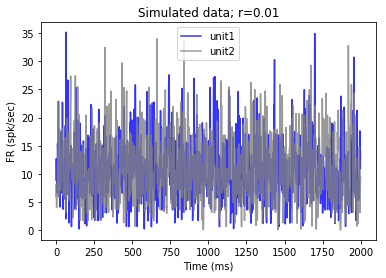

In [28]:
plt.figure()
plt.plot(gaussian_filter(spcounts1.mean(0), 1)*1000, c='blue', alpha=0.8, label='unit1')
plt.plot(gaussian_filter(spcounts2.mean(0), 1)*1000, c='gray', alpha=0.8, label='unit2')

print(np.corrcoef(psth1, psth2))
plt.legend()
#plt.ylim([0,20])
plt.ylabel('FR (spk/sec)')
plt.xlabel('Time (ms)')
plt.title('Simulated data; r=0.01')
plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/dynamics_ccg/dynamics_example_simulated_random_withsync.pdf')

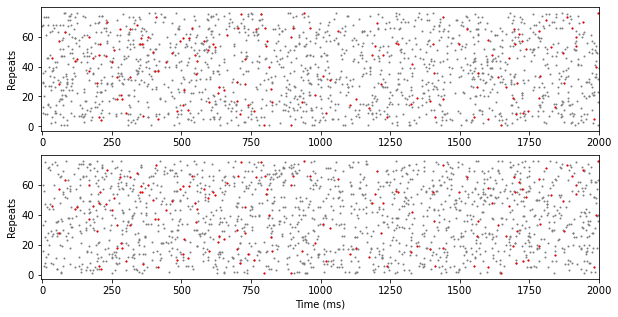

In [94]:
plt.figure(figsize=(10,5))
plt.subplot(211)
for i,temp in enumerate(spcounts1):
    # plot raster for all units in a given time window or trial
    if i<=75:
        x = np.where(temp!=0)[0]
        y = np.ones(len(x))*(i+1)
        plt.plot(x, y, '.', c='gray', markersize=2)
        plt.tick_params(direction='out')
    
for i,temp in enumerate(new):
    # plot raster for all units in a given time window or trial
    if i<=75:
        x = np.where(temp!=0)[0]
        y = np.ones(len(x))*(i+1)
        plt.plot(x, y, '.', c='r', markersize=2)
        plt.tick_params(direction='out')
plt.xlim([-5,2000])
plt.ylabel('Repeats')

plt.subplot(212)
for i,temp in enumerate(spcounts2):
    # plot raster for all units in a given time window or trial
    if i<=75:
        x = np.where(temp!=0)[0]
        y = np.ones(len(x))*(i+1)
        plt.plot(x, y, '.', c='gray', markersize=2)
        plt.tick_params(direction='out')
    
for i,temp in enumerate(new):
    # plot raster for all units in a given time window or trial
    if i<=75:
        x = np.where(temp!=0)[0]
        y = np.ones(len(x))*(i+1)
        plt.plot(x, y, '.', c='r', markersize=2)
        plt.tick_params(direction='out')
plt.xlim([-5,2000])
plt.xlabel('Time (ms)')
plt.ylabel('Repeats')
plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/dynamics_ccg/dynamics_example_simulated_random_withsync_new2.pdf')


[[ 1.         -0.03703812]
 [-0.03703812  1.        ]]
0.09468937875751503
10.92 11.115


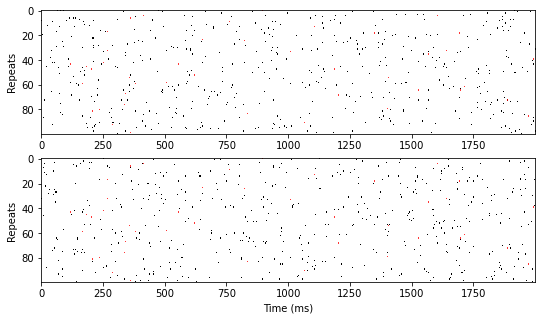

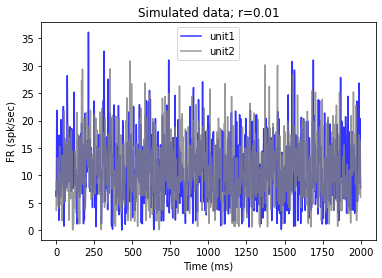

In [69]:
# Simulation 2
repeat=100
t_len=2000
spcounts1 = np.array([possion_times_rate(0.01, t_len) for i in range(repeat)])
spcounts2 = np.array([possion_times_rate(0.01, t_len) for i in range(repeat)])

print(np.corrcoef(spcounts1.mean(0), spcounts2.mean(0)))

# synchronized spikes
new = np.array([possion_times_rate(0.001, t_len) for i in range(repeat)])

print(sum(new.flatten())/sum(spcounts1.flatten()))

#print(len(np.where(new.flatten()==1)[0])/200000.)

# generate the colors for your colormap
color1 = colorConverter.to_rgba('white')
color2 = colorConverter.to_rgba('black')

# make the colormaps
cmap1 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap2',[color1,color2],256)
cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap',['white','red'],256)

cmap2._init() # create the _lut array, with rgba values

# create your alpha array and fill the colormap with them.
# here it is progressive, but you can create whathever you want
alphas = np.linspace(0, 0.8, cmap2.N+3)
cmap2._lut[:,-1] = alphas

plt.figure(figsize=(10,5))
plt.subplot(211)
#plt.imshow(spcounts1, cmap='binary', aspect=5, interpolation='none', vmax=1, vmin=0)
#plt.imshow(new, cmap='Reds', aspect=5, interpolation='none', vmax=1, vmin=0)
plt.imshow(spcounts1, cmap=cmap1, aspect=5, interpolation='none', vmax=1, vmin=0)
plt.imshow(new, cmap=cmap2, aspect=5, interpolation='none', vmax=1, vmin=0)

plt.ylabel('Repeats')

plt.subplot(212)
plt.imshow(spcounts2, cmap=cmap1, aspect=5, interpolation='none', vmax=1, vmin=0)
plt.imshow(new, cmap=cmap2, aspect=5, interpolation='none', vmax=1, vmin=0)
plt.xlabel('Time (ms)')
plt.ylabel('Repeats')
#plt.show()
#plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/dynamics_ccg/positive_control_poisson_raster.pdf')


spcounts1 = spcounts1+new
spcounts2 = spcounts2+new

spcounts1[spcounts1 > 1] = 1
spcounts2[spcounts2 > 1] = 1

FR1 = np.mean(spcounts1.sum(1)/2.)
FR2 = np.mean(spcounts2.sum(1)/2.)
print(FR1, FR2)

plt.figure()
plt.plot(gaussian_filter(spcounts1.mean(0), 1)*1000, c='blue', alpha=0.8, label='unit1')
plt.plot(gaussian_filter(spcounts2.mean(0), 1)*1000, c='gray', alpha=0.8, label='unit2')

plt.legend()
#plt.ylim([0,20])
plt.ylabel('FR (spk/sec)')
plt.xlabel('Time (ms)')
plt.title('Simulated data; r=0.01')
#plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/dynamics_ccg/dynamics_example_simulated_random_withsync_new.pdf')

# compute CCGs

In [70]:
# input shape is time*neuron*ori*rep
jitterwindow=25
n_t = np.shape(spcounts1)[1]
NFFT = int(nextpow2(2*n_t))
t = np.arange(-(n_t-1),(n_t-1))
theta = n_t-np.abs(t)

# jittered PSTH
# Jitter method keeps PSTH shape but shuffle spike times within jitter window.
# Used 'shuffle jitter' metthod to permute trial label of single spikes within jitter window.
# Thus the trial averaged PSTH show the exact same shape as original PSTH
# This method detect fast non-event locked correlation.
ttemp1 = jitter_1d(spcounts1.T,jitterwindow)  
ttemp2 = jitter_1d(spcounts2.T,jitterwindow)
tempjitter = xcorrfft(ttemp1.T, ttemp2.T,NFFT)
        
ccg = xcorrfft(spcounts1,spcounts2,NFFT)


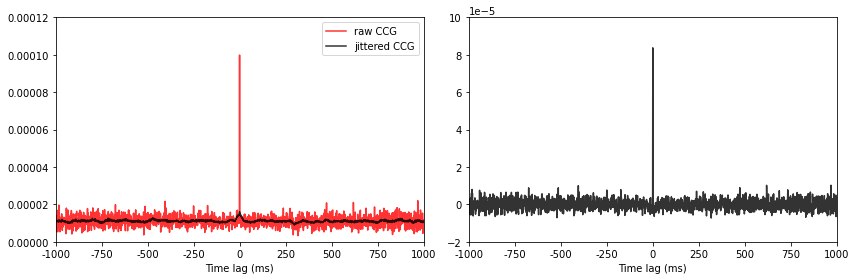

In [72]:
# xcorr capture correlation in the PSTH
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(ccg.mean(0)[int(4096/2)-int(3998/2):int(4096/2)+int(3998/2)]/theta/np.sqrt(FR1*FR2), c='red', alpha=0.8, label='raw CCG')
plt.plot(tempjitter.mean(0)[int(4096/2)-int(3998/2):int(4096/2)+int(3998/2)]/theta/np.sqrt(FR1*FR2), c='k', alpha=0.8, label='jittered CCG')
plt.xlim([int(3998/2)-1000,int(3998/2)+1000])
plt.ylim([0,0.00012])
#plt.ylim([0.225,0.240])
#plt.plot([2000, 2000],[0.0002,0.0012],':k')
plt.xticks(np.arange(1000,3001, 250), np.arange(-1000, 1001, 250))
plt.xlabel('Time lag (ms)')
plt.legend()

# sharp peak exist with synchronized spikes
plt.subplot(122)
plt.plot(((ccg.mean(0)-tempjitter.mean(0))[int(4096/2)-int(3998/2):int(4096/2)+int(3998/2)]/theta/np.sqrt(FR1*FR2)), 'k', alpha=0.8,)
#plt.plot([250,250],[0, 0.002])
plt.xlim([int(3998/2)-1000,int(3998/2)+1000])
plt.ylim([-0.00002,0.0001])
#plt.plot([2000, 2000],[-0.0002,0.0006],':k')
plt.xticks(np.arange(1000,3001, 250), np.arange(-1000, 1001, 250))
plt.xlabel('Time lag (ms)')
plt.tight_layout()
plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/dynamics_ccg/positive_control_Poisson_new.pdf')